<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]
!pip install gdown

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [ ]:
# скачаем данные

# Ссылка на данные: https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia
!gdown https://drive.google.com/uc?id=13HBOZ2QEJjCyM9ZZ70C44cyscREIsT6U

# Ссылка на данные: http://sophist.hse.ru/hse/1/tables/CPI_M_CHI.htm
!gdown https://drive.google.com/uc?id=1BsGqndPLRe0XGeOwH3-W09LE2h4FKDiE

Downloading...
From: https://drive.google.com/uc?id=13HBOZ2QEJjCyM9ZZ70C44cyscREIsT6U
To: /content/daily_electricity.csv
100% 238k/238k [00:00<00:00, 59.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BsGqndPLRe0XGeOwH3-W09LE2h4FKDiE
To: /content/data.xlsx
100% 31.5k/31.5k [00:00<00:00, 33.4MB/s]


In [ ]:
# Небольшая функция для предобработки
def preprocess_series(data, freq='M'):
    data.index = pd.PeriodIndex(data['date'], freq=freq)
    data.drop('date', axis=1, inplace=True)

    return data

In [ ]:
# считаем файлы

# Ежедневные данные - спрос и цена на электроэнергию
ts1 = pd.read_csv('daily_electricity.csv')
ts1 = preprocess_series(ts1, freq='D')
# Месячные данные - индекс потребительских цен в России
ts2 = pd.read_excel('data.xlsx')['CPI_M_CHI']
# Небольшая предобработка
ts2 = ts2[1:].astype(np.float32)
ts2.index = pd.period_range('1992-01', '2021-01', freq='M')

In [ ]:
ts1.head()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [ ]:
ts2.head()

1992-01    345.0
1992-02    138.0
1992-03    130.0
1992-04    122.0
1992-05    112.0
Freq: M, Name: CPI_M_CHI, dtype: float32

In [ ]:
# сделаем разбиение на train/test
from sktime.forecasting.model_selection import temporal_train_test_split

ts1_y_train, ts1_y_test = temporal_train_test_split(ts1['demand'], test_size=0.1)
ts2_y_train, ts2_y_test = temporal_train_test_split(ts2['2000-01':], test_size=24)

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

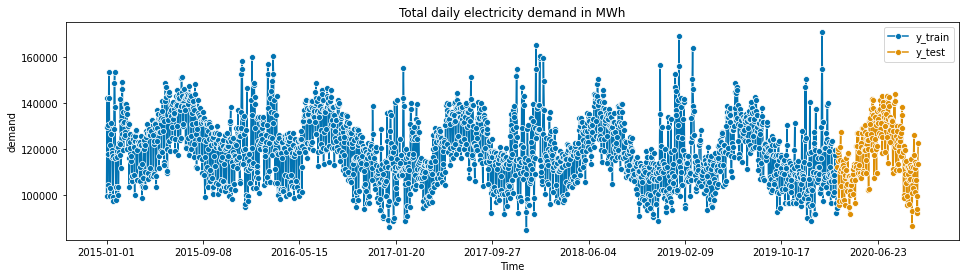

In [ ]:
# отрисуем временные ряды
from sktime.utils.plotting import plot_series

plot_series(ts1_y_train, ts1_y_test, labels=["y_train", "y_test"])
plt.title('Total daily electricity demand in MWh')
plt.xlabel('Time')
plt.show()

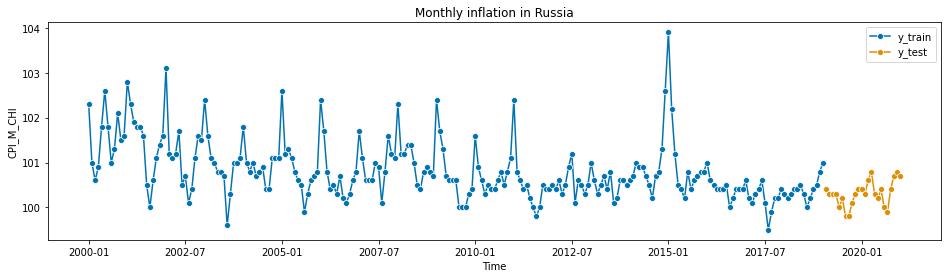

In [ ]:
plot_series(ts2_y_train['2000-01':], ts2_y_test, labels=["y_train", "y_test"])
plt.title('Monthly inflation in Russia')
plt.xlabel('Time')
plt.show()

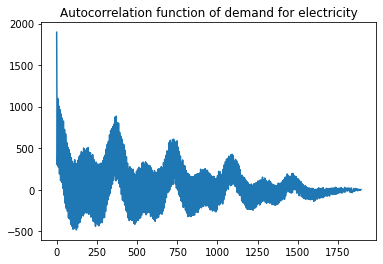

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

# Небольшая функция для реализации АКФ
def plot_cross_corr(ts, label=''):
    # Нормализуем
    ts_normed = (ts - np.mean(ts)) / np.std(ts)
    # Корреляция
    ts_corr = np.correlate(ts_normed, ts_normed, mode='full')
    plt.plot(ts_corr[ts_corr.size//2:])
    plt.title('Autocorrelation function of ' + label)
    plt.show()

# Автокорреляционная функция для спроса на электричество
plot_cross_corr(ts1_y_train, label='demand for electricity')

Судя по графику автокорреляции (да и по основному графику тоже), спрос на электричество сезонный. График повторояется приблизительно каждый год. 

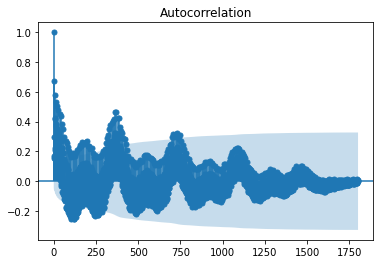

In [ ]:
# Сравним со статмоделс. Сходятся
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(ts1_y_train, lags=1800)
plt.show()

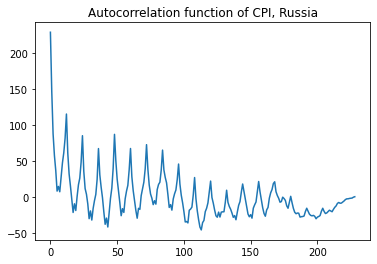

In [ ]:
# Автокорреляционная функция для ИПЦ в России с 2000 года
plot_cross_corr(ts2_y_train['2000-01':], label='CPI, Russia')

В индексе потребительских цен наблюдается очевидная сезонность, вероятно, с годовой переодичностью.

In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

# Функция для скользящего окна https://habr.com/ru/post/489734/#1d
# Rolling 1D window for ND array 
def roll(a,      # ND array
         b,      # rolling 1D window array
         dx=1):  # step size (horizontal)
    shape = a.shape[:-1] + (int((a.shape[-1] - b.shape[-1]) / dx) + 1,) + b.shape
    strides = a.strides[:-1] + (a.strides[-1] * dx,) + a.strides[-1:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

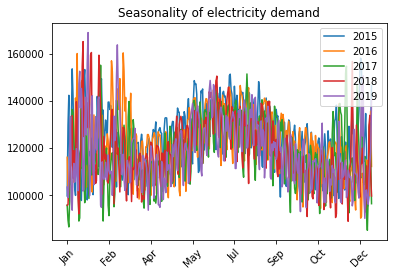

In [ ]:
# Покажем сезонность на графике (2020 год обрезан)
# Видно, что зимой спрос повышенный
plt.plot(roll(np.array(ts1_y_train), np.arange(365), 365).T)
plt.xticks(np.arange(0, 351, 50), 
           ts1_y_train.index[np.arange(0, 351, 50)].strftime('%b'),
           rotation=45)
plt.legend(np.arange(2015, 2020))
plt.title('Seasonality of electricity demand')
plt.show()

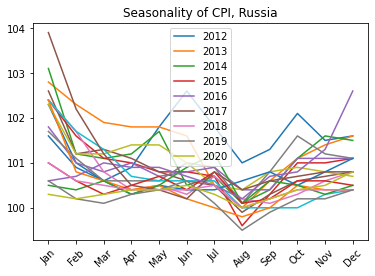

In [ ]:
# Сезоннось определенно есть
plt.plot(roll(np.array(ts2_y_train), np.arange(12), 12).T)
plt.xticks(np.arange(0, 12, 1), 
           ts2_y_train.index[np.arange(0, 12, 1)].strftime('%b'),
           rotation=45)
plt.legend(np.arange(2012, 2021))
plt.title('Seasonality of CPI, Russia')
plt.show()

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError
MAE = MeanAbsoluteError()

# ваш код обучения моделей здесь
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts2_y_train)
ts2_y_pred = forecaster.predict(np.arange(len(ts2_y_test)) + 1)

MAE наивного прогноза: 0.6916656494140625


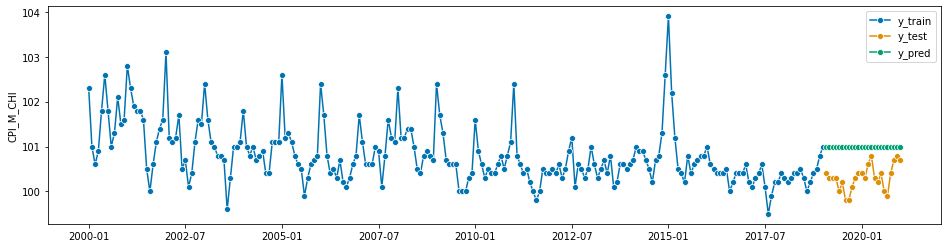

In [ ]:
# посчитайте метрики на test

# Качество так себе
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE наивного прогноза: {MAE(ts2_y_test, ts2_y_pred)}')

In [ ]:
# Наивный прогноз с сезонностью
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(ts2_y_train)
ts2_y_pred = forecaster.predict(np.arange(len(ts2_y_test)) + 1)

MAE наивного прогноза (+ сезонность): 0.21666653454303741


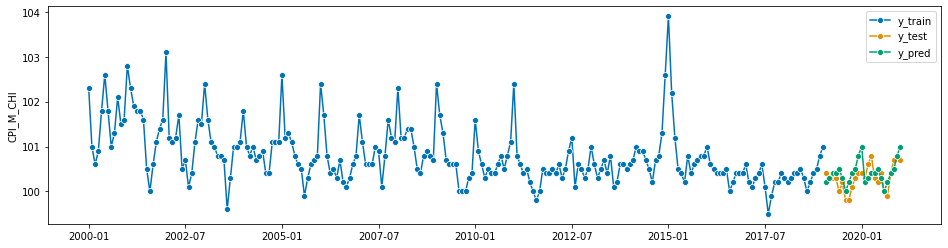

In [ ]:
# Прогноз с сезонностью уже намного лучше, чем просто последнее значение
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE наивного прогноза (+ сезонность): {MAE(ts2_y_test, ts2_y_pred)}')

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь

forecaster = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
forecaster.fit(ts2_y_train)
ts2_y_pred = forecaster.predict(np.arange(len(ts2_y_test)) + 1)

SARIMA(1, 1, 1)(1, 0, 0, 12): 0.1855897864606509


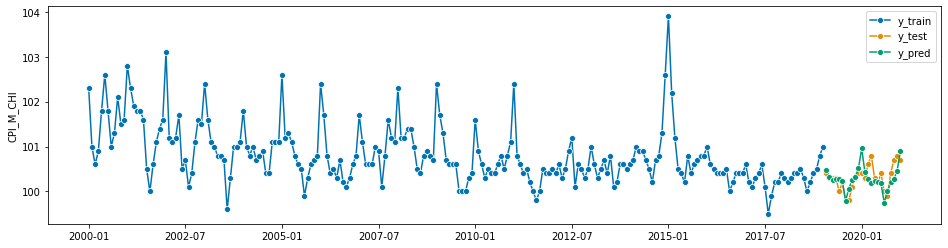

In [ ]:
# Немного лучше, чем наивный прогноз с сезонностью :)
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'SARIMA(1, 1, 1)(1, 0, 0, 12): {MAE(ts2_y_test, ts2_y_pred)}')

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(ts2_y_train)
ts2_y_pred = forecaster.predict(np.arange(len(ts2_y_test)) + 1)

AutoARIMA: 0.1885497765731022


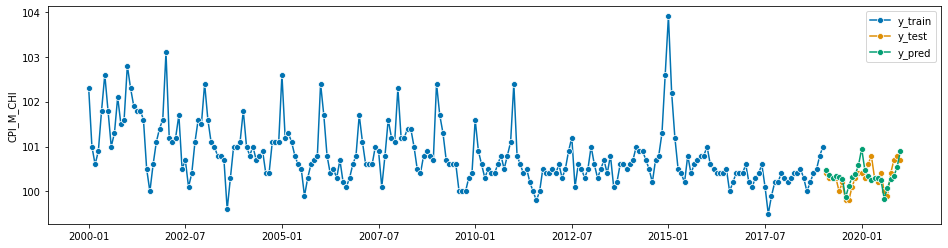

In [ ]:
# Автоподбор алгоритма оказался совсем чуть-чуть хуже, чем "ручная" модель SARIMA
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'AutoARIMA: {MAE(ts2_y_test, ts2_y_pred)}')

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

# ваш код обучения моделей здесь
df = pd.DataFrame(ts2_y_train)
df.index = np.arange(len(df.index))
df['T'] = pd.period_range('2000-01', '2019-01', freq='M').to_timestamp()

forecaster = LGTFull(
    response_col='CPI_M_CHI',
    date_col='T',
    seasonality=12,
    seed=30052021
)

forecaster.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2af9ff5e07f97061bbe4badb0f8a2e36 NOW.


MAE of LGT model: 0.20293136738379758


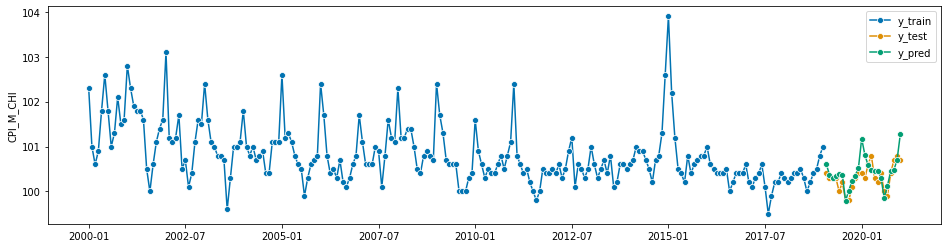

In [ ]:
# посчитайте метрики на test

# МАЕ колеблется в районе 0.18 - 0.24 в зависимости от итерации
test_df = pd.DataFrame(ts2_y_test)
test_df.index = np.arange(len(test_df.index))
test_df['T'] = pd.period_range('2019-02', '2021-01', freq='M').to_timestamp()

ts2_y_pred = forecaster.predict(test_df)['prediction']
ts2_y_pred.index = ts2_y_test.index
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE of LGT model: {MAE(ts2_y_pred, ts2_y_test)}')

In [ ]:
forecaster = DLTFull(
    response_col='CPI_M_CHI',
    date_col='T',
    seasonality=12,
    seed=30052021
)

forecaster.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MAE of DLT model: 0.22132681811248509


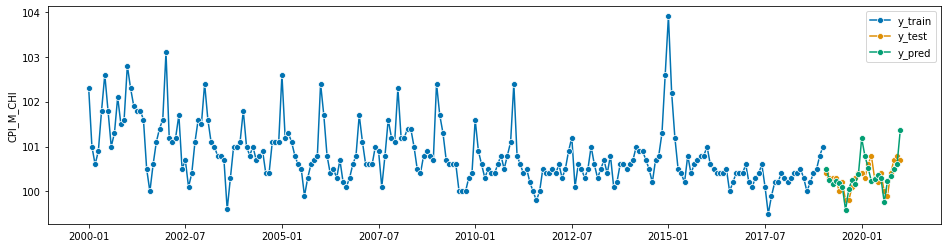

In [ ]:
# Прогноз у DLT также колеблется и MAE примерно в тех же пределах
ts2_y_pred = forecaster.predict(test_df)['prediction']
ts2_y_pred.index = ts2_y_test.index
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE of DLT model: {MAE(ts2_y_pred, ts2_y_test)}')

На мой взгляд, модель SARIMA(1, 1, 1)(1, 0, 0, 12) является наилучшей, поскольку дает наименьшую ошибку на тестовых данных и не имеет случайностей. Для более глубоких выводов необходимо валидировать модели скользящим или расширяющимся окном.

In [ ]:
# Пример кросс-валидации расширяющимся окном
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter

forecaster = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), suppress_warnings=True)
cv = ExpandingWindowSplitter(
    initial_window=24,
    step_length=12,
    fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
results = evaluate(forecaster=forecaster,
                   y=ts2['2000-01':],
                   cv=cv,
                   scoring=MAE)

In [ ]:
print('Среднее значение MAE расширяющимся окном: {}'.format(results['test_MeanAbsoluteError'].mean()))

Среднее значение MAE расширяющимся окном: 0.3092406840566954


Видно, что на валидации MAE оказалось выше. Это можно связать с тем, что на начальных итерациях расширяющегося окна наблюдения для обучения модели слишком мало.

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь
forecaster = ExponentialSmoothing(
    trend='add', 
    damped_trend=True,
    seasonal='add', 
    sp=12,
)
forecaster.fit(ts2_y_train)
ts2_y_pred = forecaster.predict(np.arange(len(ts2_y_test)) + 1)

MAE of ExponentialSmoothing: 0.21120127487982465


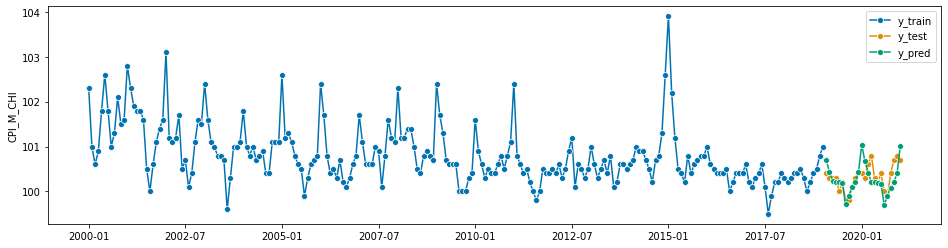

In [ ]:
# посчитайте метрики на test
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE of ExponentialSmoothing: {MAE(ts2_y_test, ts2_y_pred)}')

In [ ]:
forecaster = AutoETS(
    error='mul',
    trend='mul', 
    damped_trend=True,
    seasonal='add', 
    sp=12
)
forecaster.fit(ts2_y_train.astype(np.float64))
ts2_y_pred = forecaster.predict(np.arange(len(ts2_y_test)) + 1)

MAE of AutoETS: 0.2011529112777648


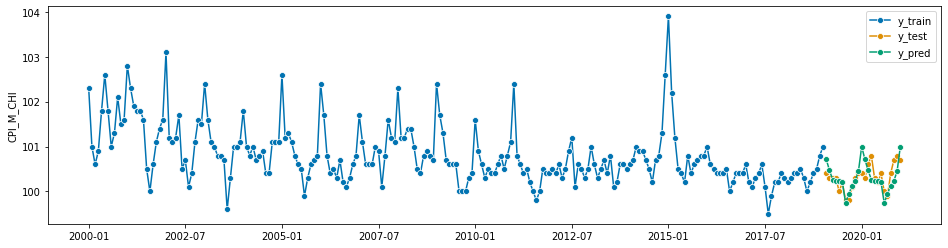

In [ ]:
# МАЕ у AutoETS немного ниже, чем у обычного экспоненциального сглаживания
plot_series(ts2_y_train, ts2_y_test, ts2_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE of AutoETS: {MAE(ts2_y_test, ts2_y_pred)}')

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания
from orbit.diagnostics.plot import plot_predicted_data

# Поскольку модели DLT и LGT довольно хороши в предсказании, а также
# в orbit уже выдаются доверительные интервалы, будем использовать DLT

# Фитим
forecaster = DLTFull(
    response_col='CPI_M_CHI',
    date_col='T',
    seasonality=12,
    seed=30052021
)

forecaster.fit(df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


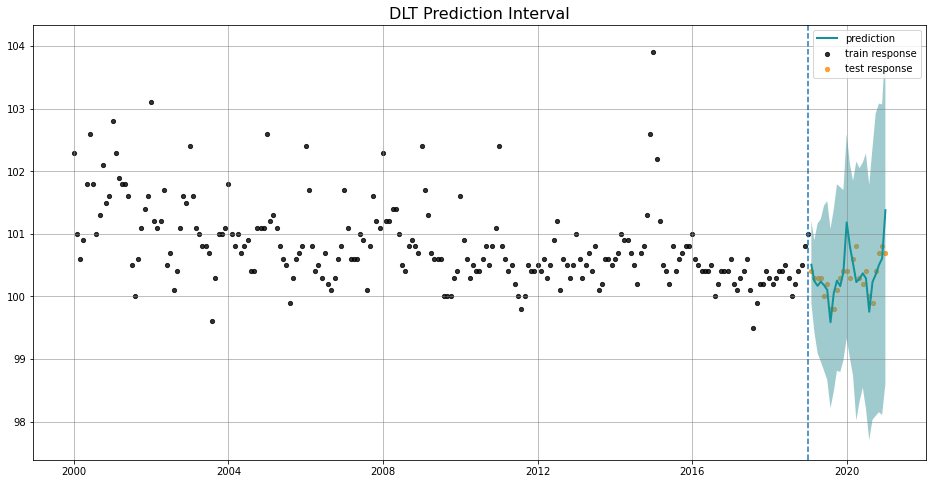

In [ ]:
# Предсказываем
ts2_y_pred = forecaster.predict(test_df)
_ = plot_predicted_data(
    df, ts2_y_pred, 'T', 'CPI_M_CHI',  
    title='DLT Prediction Interval',
    test_actual_df=test_df
)

Доверительный интервал довольно широкий для предсказания. Поскольку инфляция таргетируется в последние годы, ее дисперсия значительно меньше. Здесь проявляется консервативность модели и неопределенность будущего :) Несмотря на это, точечный прогноз хороший.

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(ts1_y_train)
ts1_y_pred = forecaster.predict(np.arange(len(ts1_y_test)) + 1)

MAE наивного прогноза: 23994.154786729872


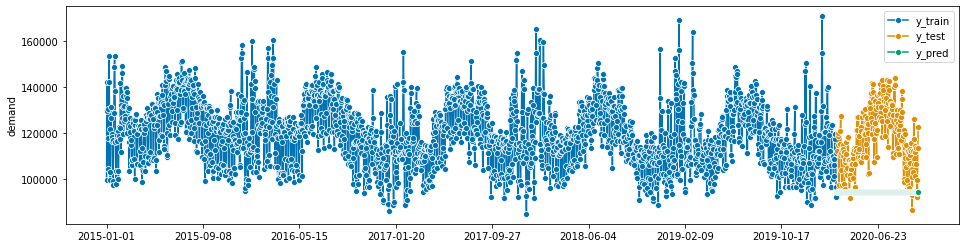

In [ ]:
# посчитайте метрики на test
plot_series(ts1_y_train, ts1_y_test, ts1_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE наивного прогноза: {MAE(ts1_y_test, ts1_y_pred)}')

MAE наивного прогноза (с сезонностью): 9497.807227488149


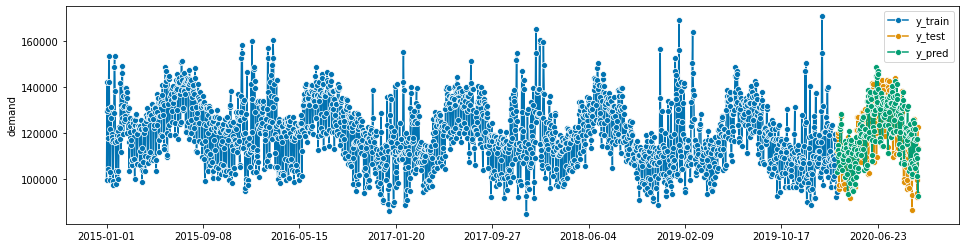

In [ ]:
# График шумный, предыдущее значение сезона хорошо предсказывает
forecaster = NaiveForecaster(sp=365, strategy="last")
forecaster.fit(ts1_y_train)
ts1_y_pred = forecaster.predict(np.arange(len(ts1_y_test)) + 1)

plot_series(ts1_y_train, ts1_y_test, ts1_y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'MAE наивного прогноза (с сезонностью): {MAE(ts1_y_test, ts1_y_pred)}')

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.stan_estimator import StanEstimatorMAP

# ваш код обучения моделей здесь
# Нужно прологорифмировать ряд, иначе не обучается
df = pd.DataFrame(np.log(ts1_y_train))
df.index = np.arange(len(df.index))
df['T'] = pd.period_range(ts1_y_train.index[0], ts1_y_train.index[-1], freq='D').to_timestamp()

forecaster = KTRLiteMAP(
    response_col='demand',
    date_col='T',
    seasonality=[7, 31, 365],
    seasonality_fs_order=[2, 3, 6],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.3,
    estimator_type=StanEstimatorMAP,
    seed=30052021
)

forecaster.fit(df)

MAE of KTRLiteMAP: 6869.038854909041


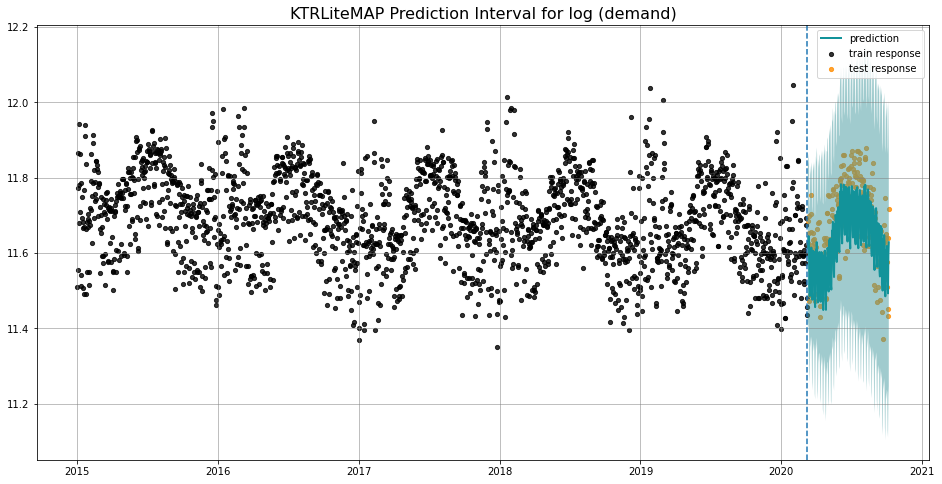

In [ ]:
# посчитайте метрики на test
# Ошибка снизилась почти на 30% по сравнению с наивным сезонным прогнозом
test_df = pd.DataFrame(np.log(ts1_y_test))
test_df.index = np.arange(len(test_df.index))
test_df['T'] = pd.period_range(ts1_y_test.index[0], ts1_y_test.index[-1], freq='D').to_timestamp()

ts1_y_pred = forecaster.predict(test_df)
print('MAE of KTRLiteMAP: {}'
.format(MAE(ts1_y_test, np.exp(ts1_y_pred['prediction'])))
)
_ = plot_predicted_data(
    df, ts1_y_pred, 'T', 'demand',  
    title='KTRLiteMAP Prediction Interval for log (demand)',
    test_actual_df=test_df
)

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь
df = pd.DataFrame(np.log(ts1_y_train))
df.index = np.arange(len(df.index))
df['ds'] = pd.period_range(
    ts1_y_train.index[0], ts1_y_train.index[-1], freq='D'
).to_timestamp()
df.columns = ['y', 'ds']

forecaster = Prophet()

forecaster.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# посчитайте метрики на test
test_df = pd.DataFrame(np.log(ts1_y_test))
test_df.index = np.arange(len(test_df.index))
test_df['ds'] = pd.period_range(
    ts1_y_test.index[0], ts1_y_test.index[-1], freq='D'
).to_timestamp()
df.columns = ['y', 'ds']

ts1_y_pred = forecaster.predict(test_df)
print('MAE of Prophet: {}'
.format(MAE(ts1_y_test, np.exp(ts1_y_pred['yhat'])))
)

MAE of Prophet: 6585.512764049354


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

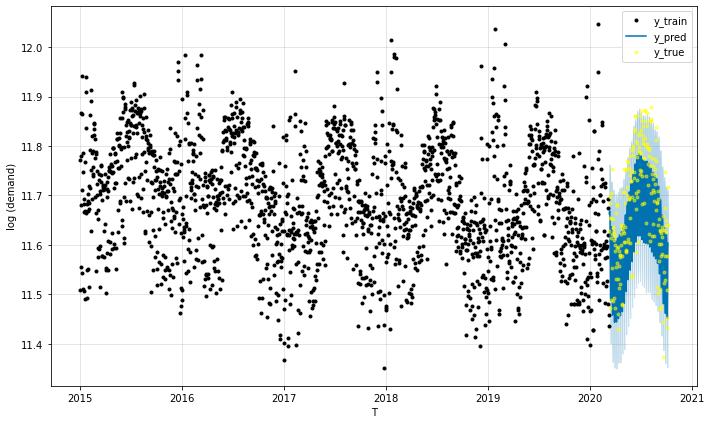

In [ ]:
# нарисуйте пресказания
fig1 = forecaster.plot(ts1_y_pred, xlabel='T', ylabel='log (demand)')
plt.plot(np.log(ts1_y_test), 'o', color='yellow', alpha=.5, markersize=3)
plt.legend(['y_train', 'y_pred', 'y_true'])
plt.show()

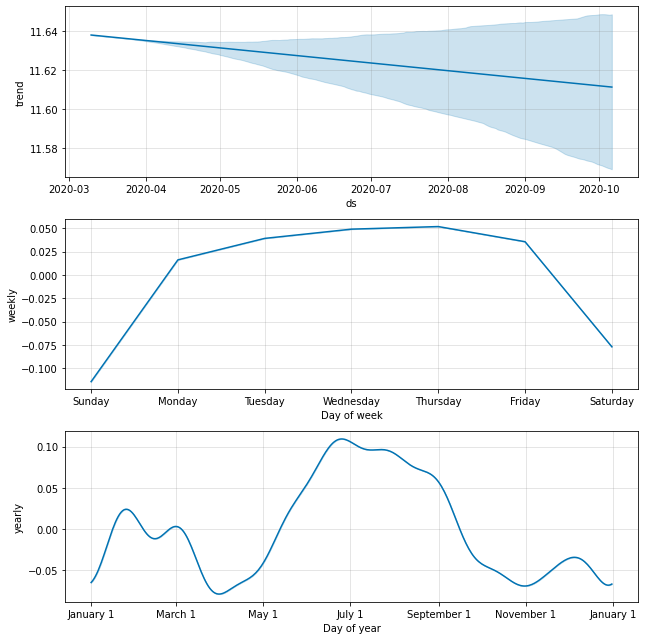

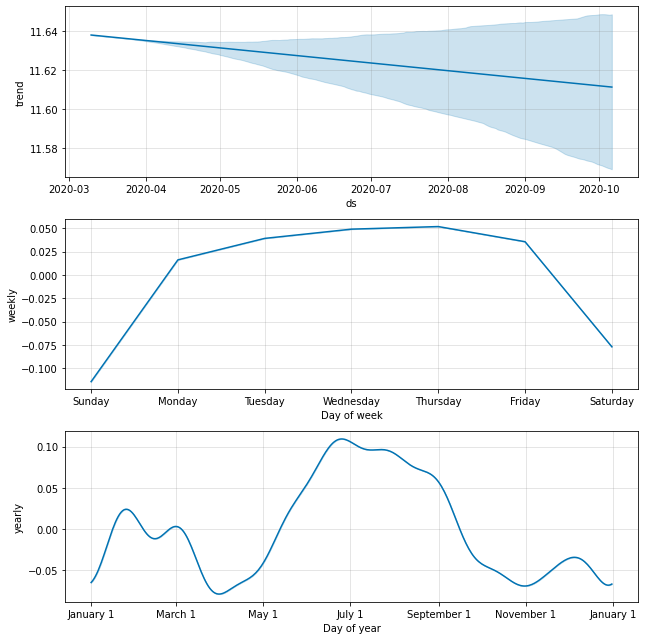

In [ ]:
# Можно даже посмотреть каждую из компонент прогноза :)
forecaster.plot_components(ts1_y_pred)

Модель *Prophet* с параметрами по умолчанию оказалась несколько лучше по качеству, чем *KTRLiteMAP*. На графике видно, что большинство настоящих значений лежат в пределах доверительного интервала предсказаний.

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [ ]:
!pip install arviz
!pip install pystan

In [ ]:
import pystan
import arviz as az

In [ ]:
# ваш код модели на STAN и её обучения моделей здесь

# КОД С ЛЕКЦИИ (без регрессора)
model_code = """
data {
    int<lower=0> n; // number of observations
    vector[n] y;    // ts data
}
parameters {
    // equation parameters
    real<lower=0, upper=1> alpha;
    real<lower=0, upper=1> beta;
    real<lower=0, upper=1> gamma;
    real<lower=0, upper=1> theta;
    real<lower=0> sigma;

    // initial values
    real linit;
    real binit;
    vector[365] sinit;
}
transformed parameters {
    vector[n+1] l;
    vector[n+1] b;
    vector[n+365] s;
    vector[n] yhat;

    // initial observations
    l[1] = linit;
    b[1] = binit;
    for (t in 1:365) {
        s[t] = sinit[t];
    }

    // update equations
    for (t in 1:n) {
        int tp;
        int ts;
        tp = t + 1;
        ts = t + 365;

        b[tp] = (1 - beta) * theta * b[tp-1] + beta * (y[t] - l[tp-1] - s[ts-365]);
        s[ts] = s[ts-365] + gamma * (y[t] - l[tp-1] - theta * b[tp-1] - s[ts-365]);
        l[tp] = (1 - alpha) * (l[tp-1] + theta * b[tp-1]) + alpha * (y[t] - s[ts-365]);
        yhat[t] = l[tp-1] + theta * b[tp-1] + s[ts-365];
    }
}
model {
    // prior for e-parameters
    alpha ~ uniform(0, 1);
    beta ~ uniform(0, 1);
    theta ~ uniform(0, 1);
    gamma ~ uniform(0, 1);
    sigma ~ normal(0, 10) T[0, ];

    // prior for initial values
    linit ~ normal(0, 10);
    binit ~ normal(0, 10);
    sinit ~ normal(0, 10);

    // likelihood for observed data
    for (t in 1:n) {
        y[t] ~ normal(yhat[t], sigma);
    }
}
"""

forecaster = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52ac2fb21193c8f84c932023b2db9fbb NOW.


In [ ]:
df = {
    'n': len(ts1_y_train),
    'y': np.log(ts1_y_train).values
}

post = forecaster.sampling(df, chains=2, iter=5000, warmup=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
# посчитайте метрики на test
post


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_52ac2fb21193c8f84c932023b2db9fbb.
2 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

            mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       0.43  2.2e-3   0.06    0.31   0.39   0.43   0.47   0.55    793    1.0
beta         0.2  7.2e-3   0.25  1.4e-3   0.03   0.09   0.28   0.89   1209    1.0
gamma       0.54  1.0e-3   0.04    0.47   0.52   0.54   0.57   0.61   1292    1.0
theta        0.1  2.7e-3   0.07  3.8e-3   0.04    0.1   0.15   0.25    633    1.0
sigma       0.11  4.2e-5 2.0e-3     0.1   0.11   0.11   0.11   0.11   2306    1.0
linit       9.98    0.43    1.0    8.05   9.25  10.02  10.73  11.69      5   1.13
binit       8.66    0.25   8.81  -11.35   3.96   8.88  14.21  25.57   1261    1.0
sinit[1]    0.55    0.42   0.47   -0.19   0.15   0.49   0.93   1.47      1   2.38
sinit[2]    0.59    0.42   0.47  

In [ ]:
y_hat = post['l[1896]'] + post['theta'] * post['b[1896]'] + np.random.normal(loc=0, scale=post['sigma'])

In [ ]:
# нарисуйте пресказания
ts1_y_pred = []
y_hat = post['l[1896]'] + post['theta'] * post['b[1896]'] + np.random.normal(loc=0, scale=post['sigma'])
for i in range(len(ts1_y_test)):
    ts1_y_pred.append(y_hat)
    ...

1895